<H1> Clustering</H1>

<H2> Import and Format </H2>

In [ ]:
#setwd("~/Documents/Scripts") #change if need to change working directory

In [1]:
### Read in z_scores and format ###
z_scores = read.csv("data_mRNA_median_Zscores.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)

map = z_scores[,c(1,2)]

inst_names = colnames(z_scores)[3:length(colnames(z_scores))]

z_scores = z_scores[,-2]
z_scores = as.data.frame(t(z_scores), stringsAsFactors = FALSE)
names(z_scores) = map[,1]
z_scores = z_scores[-1,]

z_scores = as.data.frame(apply(z_scores, 2, as.numeric))

row.names(z_scores) = inst_names

<H2> Add Prognosis Markers (incomplete) </H2>
<br>
Read in standardised Markers and label each individual as good/bad prognosis. Work in Progress

In [4]:
markers = as.data.frame(read.csv('marker.csv'))
markers

up_thresh = 1
good_prog = markers[markers[,"Prognosis"] ==1,]
good_progU = good_prog[good_prog$Expression ==1,]


for (mk in good_progU[,"Marker"]){
  z_scores$prog = ifelse(z_scores[,mk] >= up_thresh, 1, 0)
}


good_progD = good_prog[good_prog$Expression == 0,]

for (mk in good_progD[,"Marker"]){
  z_scores$prog = ifelse(z_scores[,mk] < up_thresh, 1, 0)
}

bad_prog = markers[markers$Prognosis == 0,]
bad_progU = bad_prog[bad_prog$Expression ==1,]

for (mk in bad_progU[,"Marker"]){
  z_scores$prog = ifelse(z_scores[,mk] >= up_thresh, 0, 1)
}





bad_progD = bad_prog[bad_prog$Expression == 0,]

for (mk in bad_progD[,"Marker"]){
  z_scores$prog = ifelse(z_scores[,mk] < up_thresh, 0, 1)
}


Marker,Expression,Prognosis
<fct>,<int>,<int>
CHD5,1,1
ALK,1,0
CD44,0,1


<H2> Deal with Missing Vals </H2>
<br>
Remove Genes with large number of missing vals ( > thresh) 

In [4]:
### Params ###

thresh = 0 # change to vary number of allowed NAs

In [5]:
### Deal with missing vals ###

na_count = colSums(is.na.data.frame(z_scores)) # NAs in each gene

to_del = c()
for(name in names(z_scores)){ # if NA's > thresh, add to to_del list
  if(na_count[name]>thresh){
    to_del = c(to_del,name)
  }
}

z_scores = z_scores[,!(names(z_scores) %in% to_del)] #remove from list using to_del


<H2> Perform PCA </H2>

Transform dataset to capture majority of variance ( > 95%) 

In [6]:
### Perform PCA ###

z_scores_stand = as.data.frame(scale(z_scores))

#sapply(z_scores_stand,sd) #now, standard deviations are 1
#sapply(z_scores_stand,mean) #now, mean should be 0 (or very very close to 0)

pca = prcomp(z_scores_stand,scale=T) 

summary(pca)


Importance of components:
                           PC1     PC2      PC3      PC4      PC5      PC6
Standard deviation     55.5795 43.1787 34.27990 32.59070 25.17467 21.72621
Proportion of Variance  0.1673  0.1009  0.06362  0.05751  0.03431  0.02556
Cumulative Proportion   0.1673  0.2682  0.33181  0.38932  0.42363  0.44919
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     19.93222 18.51895 17.38223 16.96790 15.82460 15.22603
Proportion of Variance  0.02151  0.01857  0.01636  0.01559  0.01356  0.01255
Cumulative Proportion   0.47070  0.48927  0.50563  0.52122  0.53477  0.54732
                           PC13     PC14     PC15     PC16     PC17     PC18
Standard deviation     13.95991 13.66390 13.09997 12.79809 12.37487 12.20266
Proportion of Variance  0.01055  0.01011  0.00929  0.00887  0.00829  0.00806
Cumulative Proportion   0.55788  0.56798  0.57728  0.58614  0.59443  0.60250
                           PC19     PC20     PC21     PC22

In [7]:
pca = as.data.frame(pca$x[,1:180]) #contains 95% of variance of dataset

<H2> Remove attributes with majority small z scores </H2>
<br>
Genes with majority small z scores show little variance (therefore not all that helpful in class deliniation).

In [8]:
### Params ###

sig_thresh = 1 # threshold to remove z scores -> set arbitrarily

In [9]:
### Omit Attributes with majority small z scores ###
instances = nrow(z_scores)

maj = instances %/% 2

smallz = c()
for(name in names(z_scores)){ #for each column
  current_col = z_scores[,name]
  current_count = 0
  for(val in current_col){ #find num abs(z scores) < sig_thresh
    if(abs(val) <= sig_thresh){current_count = current_count + 1}
  }
  if(current_count > maj){smallz = c(smallz,name)} #if count > maj -> remove
}

z_scores = z_scores[,!(names(z_scores) %in% smallz)]

<H2> Dimentionality Reduced PCA </H2>

In [10]:
### dim reduced PCA ###

z_scores_stand = as.data.frame(scale(z_scores))

pca2 = prcomp(z_scores_stand,scale=T) 

summary(pca2)

Importance of components:
                           PC1    PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     11.5428 7.9946 7.11185 6.22113 5.08425 4.1888 4.03448
Proportion of Variance  0.2088 0.1002 0.07928 0.06066 0.04052 0.0275 0.02551
Cumulative Proportion   0.2088 0.3090 0.38829 0.44895 0.48947 0.5170 0.54248
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     3.69302 3.51884 3.18977 3.04096 2.89647 2.72142 2.68320
Proportion of Variance 0.02138 0.01941 0.01595 0.01449 0.01315 0.01161 0.01128
Cumulative Proportion  0.56386 0.58327 0.59921 0.61371 0.62686 0.63847 0.64975
                          PC15    PC16   PC17    PC18    PC19    PC20    PC21
Standard deviation     2.60515 2.54229 2.4364 2.36838 2.31284 2.22657 2.15384
Proportion of Variance 0.01064 0.01013 0.0093 0.00879 0.00838 0.00777 0.00727
Cumulative Proportion  0.66039 0.67052 0.6798 0.68861 0.69700 0.70477 0.71204
                          PC22    PC23

In [11]:
pca2 = as.data.frame(pca2$x[,1:124]) #contains 95% of variance of dataset

<H2> Clustering </H2>
<br>
<br>
Perform hierarchical clustering on each dataset. Also see histogram to show distribution of k=2 clustering.

In [12]:
### Clustering ###

library('cluster')

find_hierac_clust = function(data,linkage){
  dist_mat = dist(data, method = 'euclidian')
  hclust = hclust(dist_mat, method = linkage)
  plot(hclust)
  cut_avg = cutree(hclust, k = 2)
  return(cut_avg)
}

<h3> HK z scores </h3>

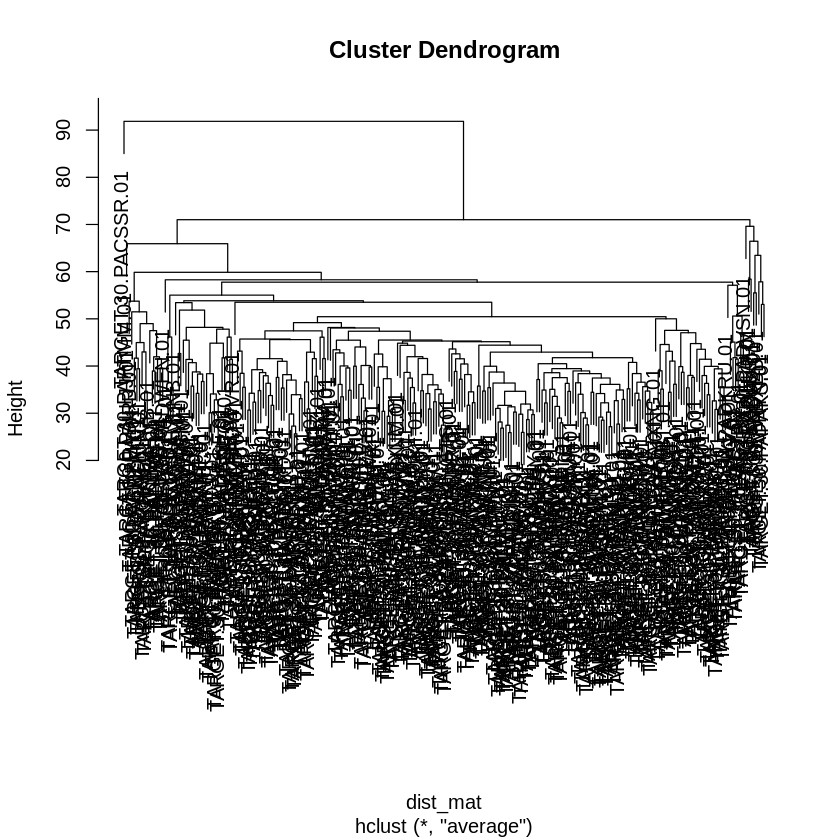

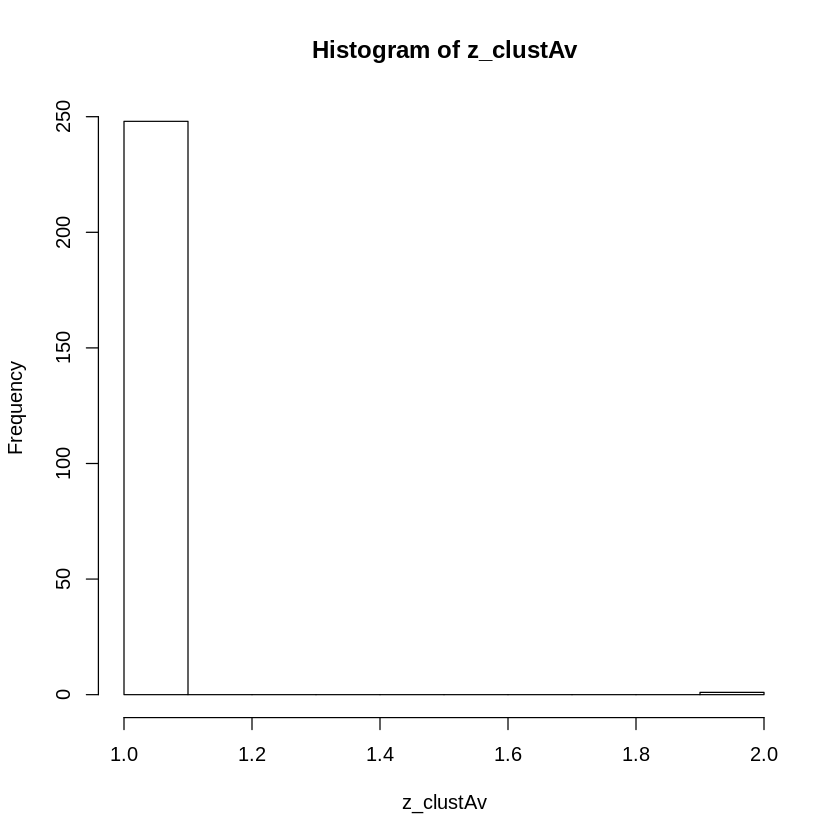

In [13]:
z_clustAv = find_hierac_clust(z_scores,'average')
hist(z_clustAv)

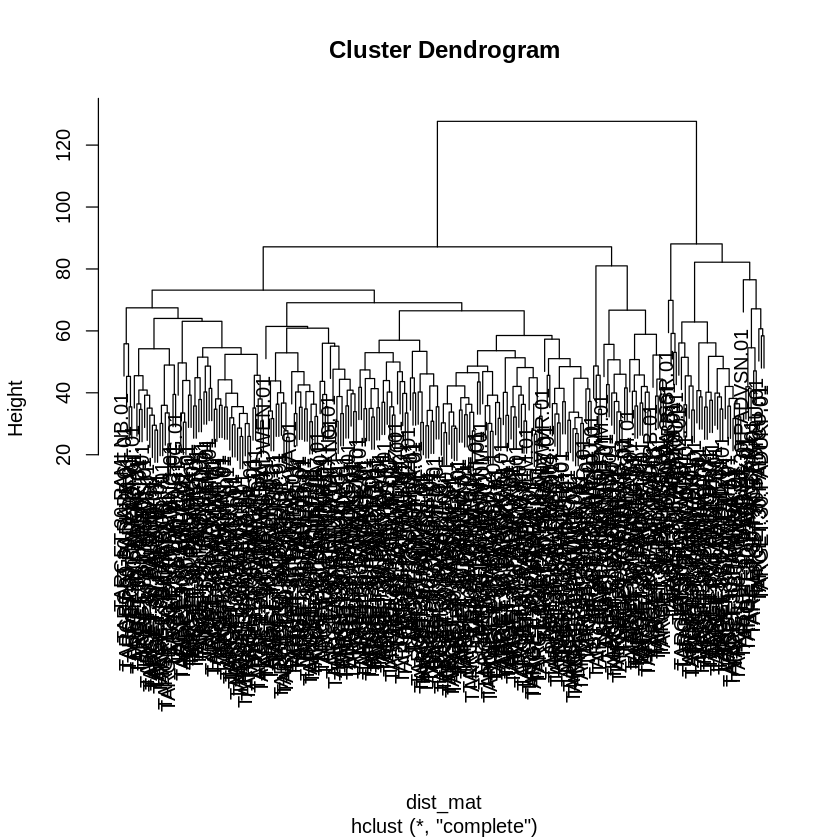

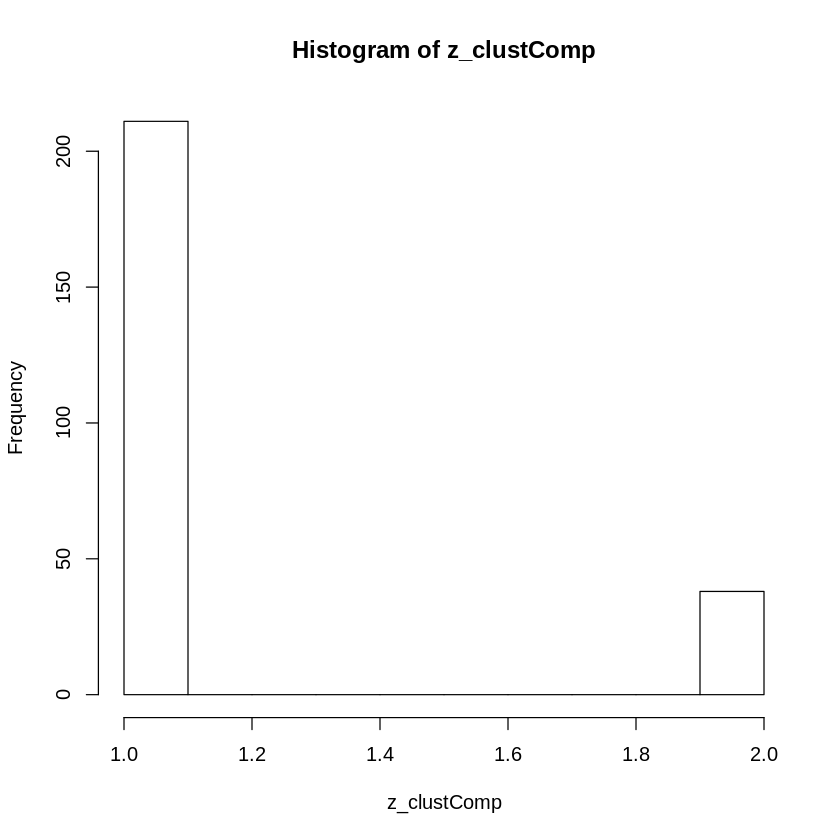

In [14]:
z_clustComp = find_hierac_clust(z_scores, 'complete')
hist(z_clustComp)

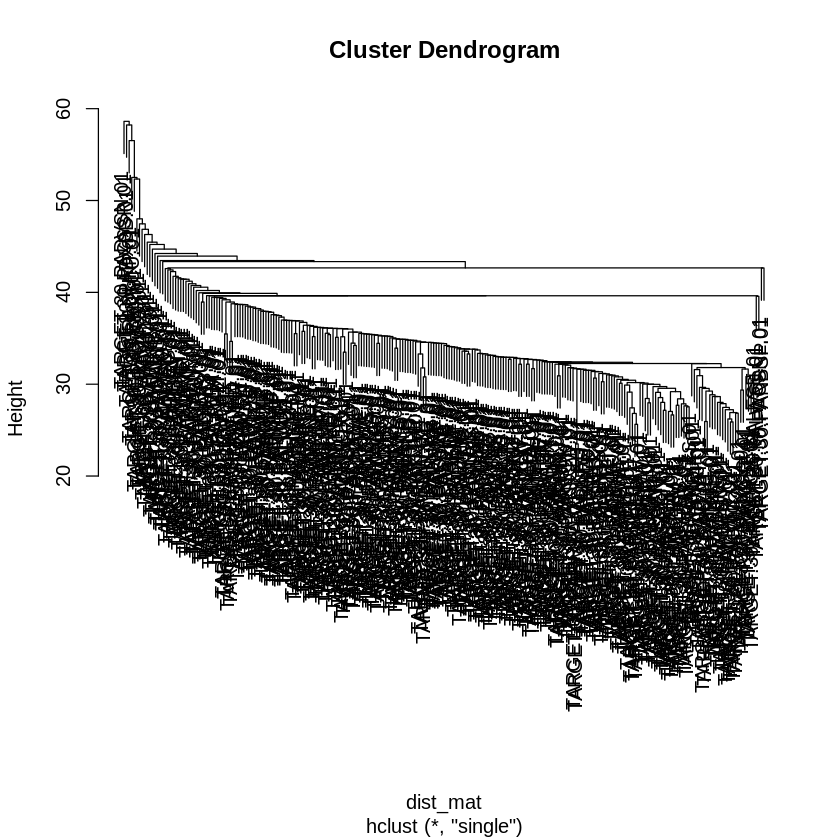

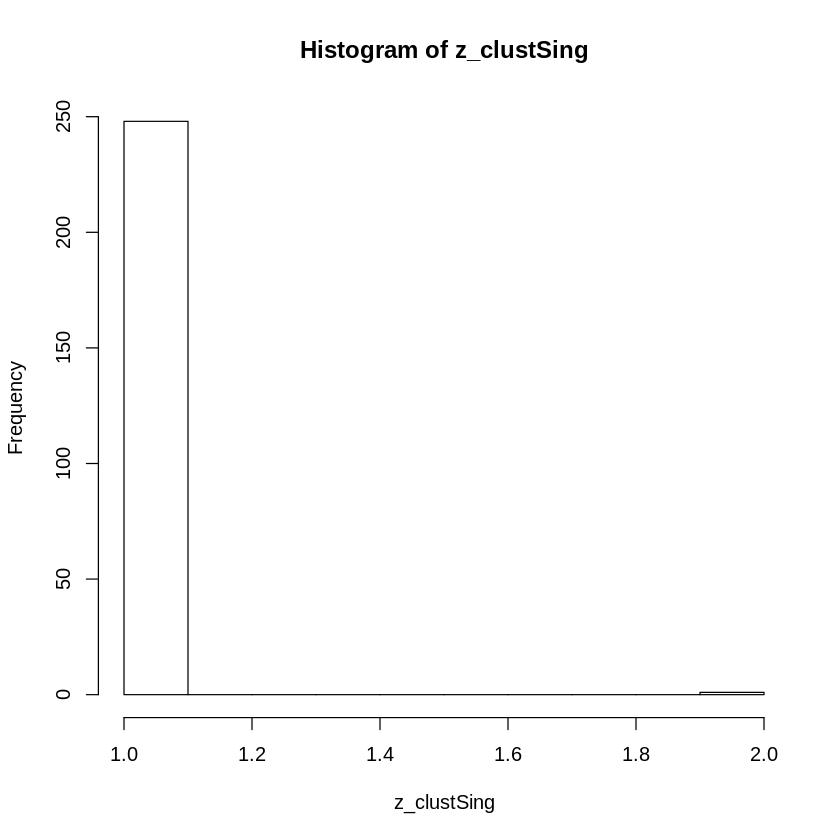

In [15]:
z_clustSing = find_hierac_clust(z_scores, 'single')
hist(z_clustSing)

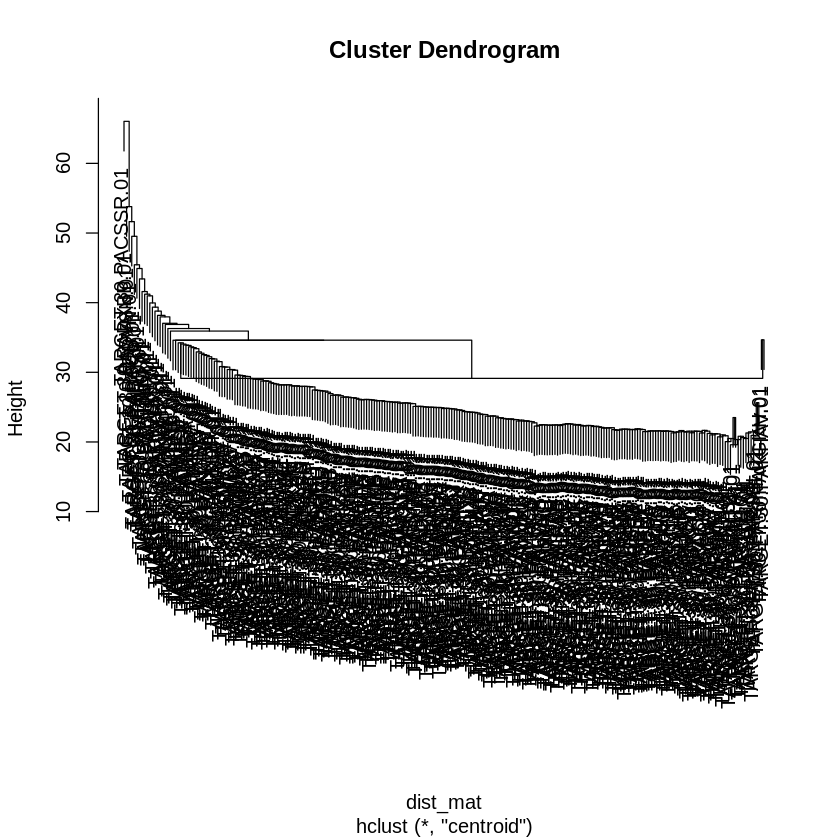

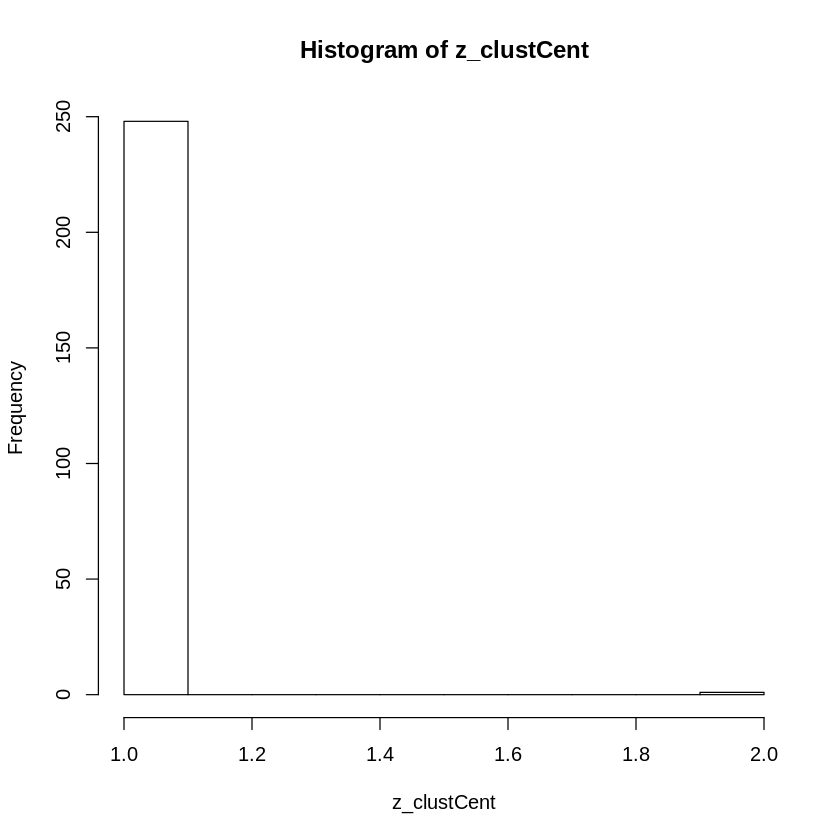

In [16]:
z_clustCent = find_hierac_clust(z_scores, 'centroid')
hist(z_clustCent)

<h3> HK PCA </h3>

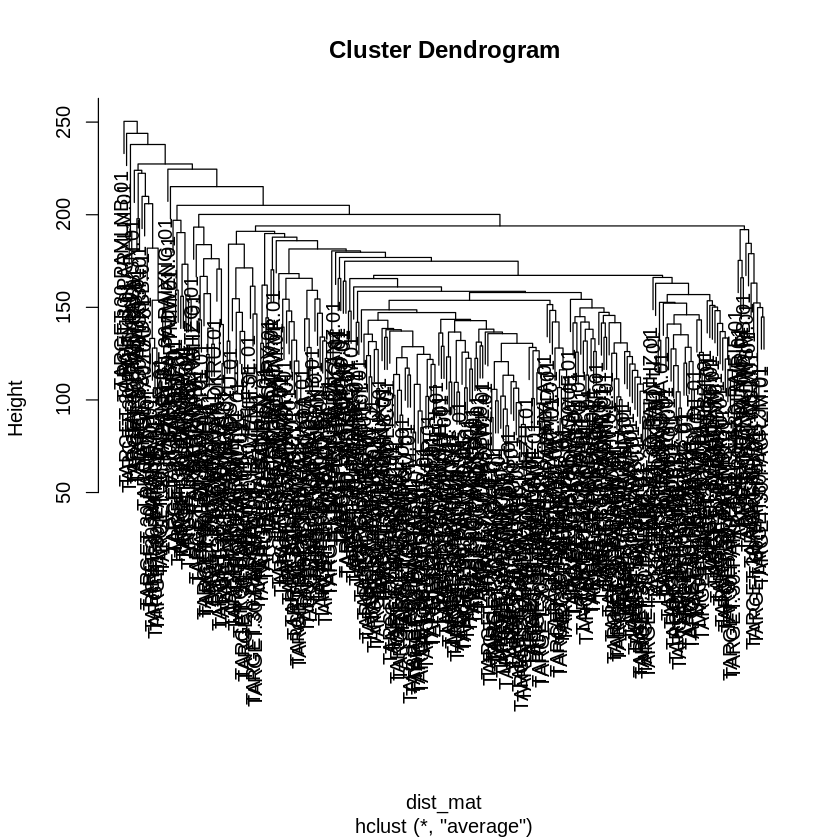

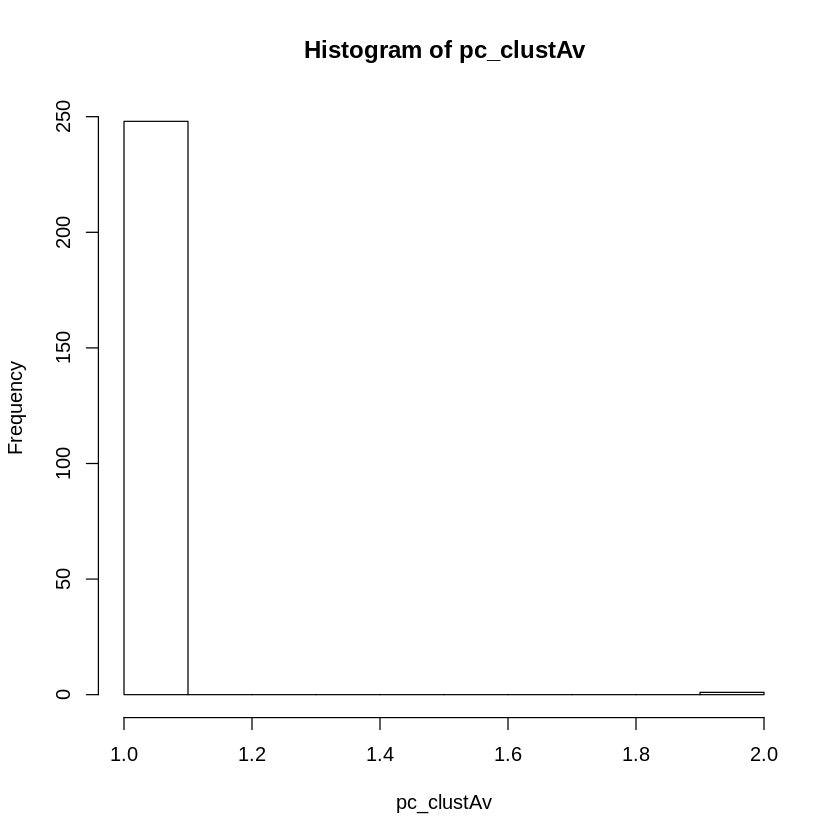

In [17]:
pc_clustAv = find_hierac_clust(pca,'average')
hist(pc_clustAv)

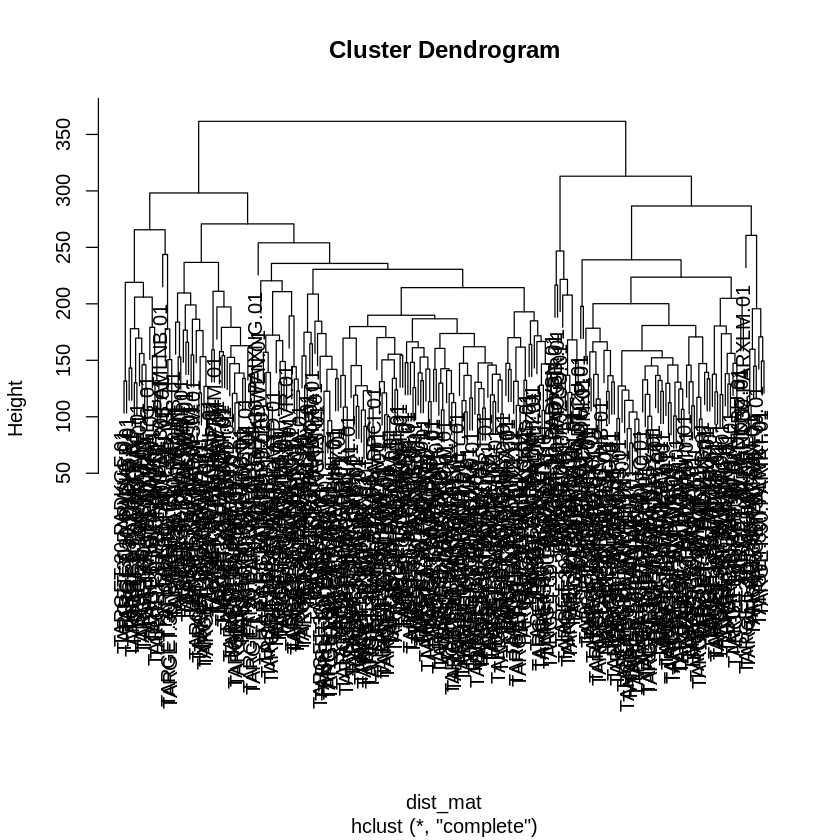

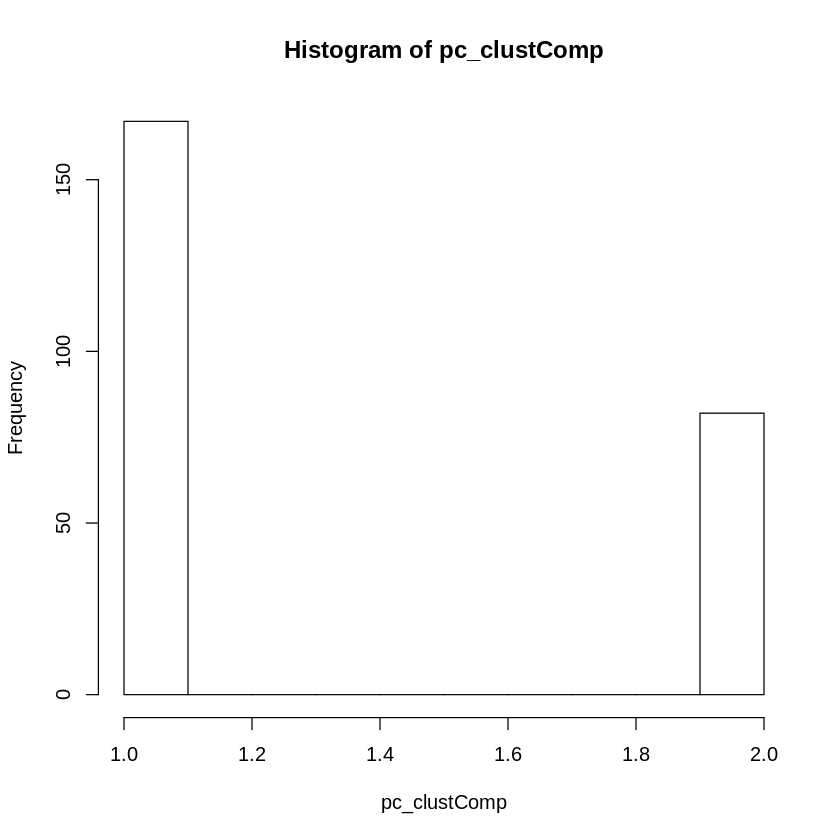

In [18]:
pc_clustComp = find_hierac_clust(pca, 'complete')
hist(pc_clustComp)

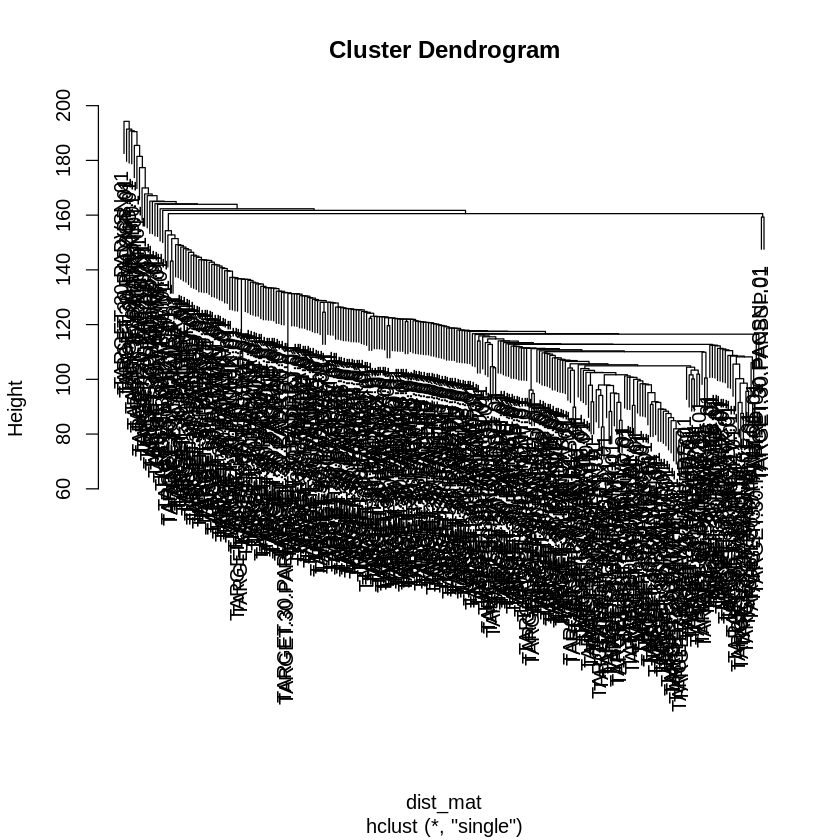

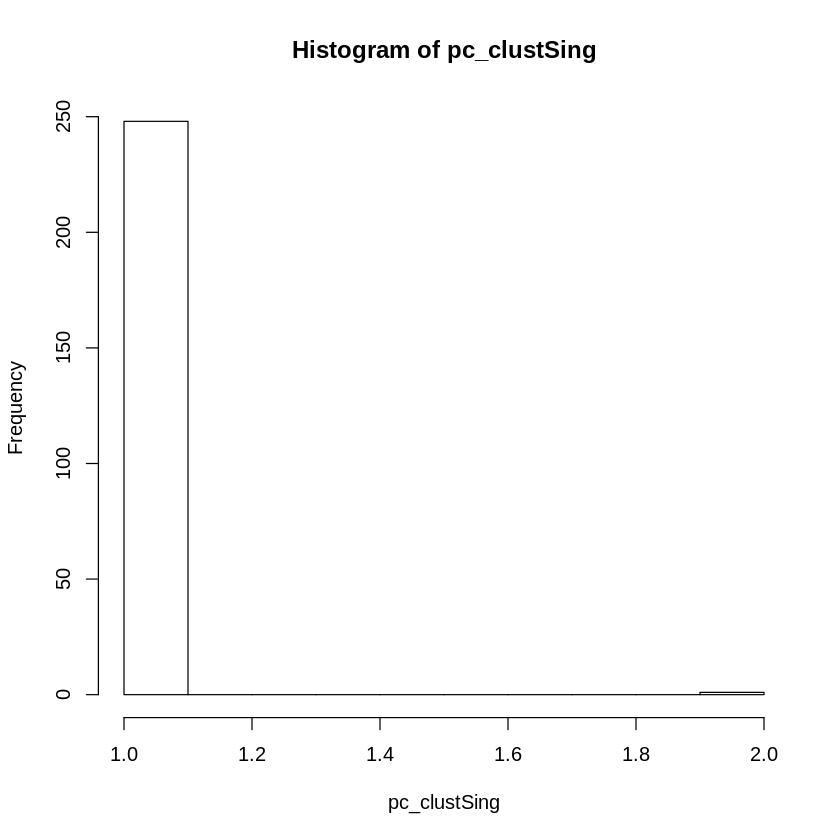

In [19]:
pc_clustSing = find_hierac_clust(pca, 'single')
hist(pc_clustSing)

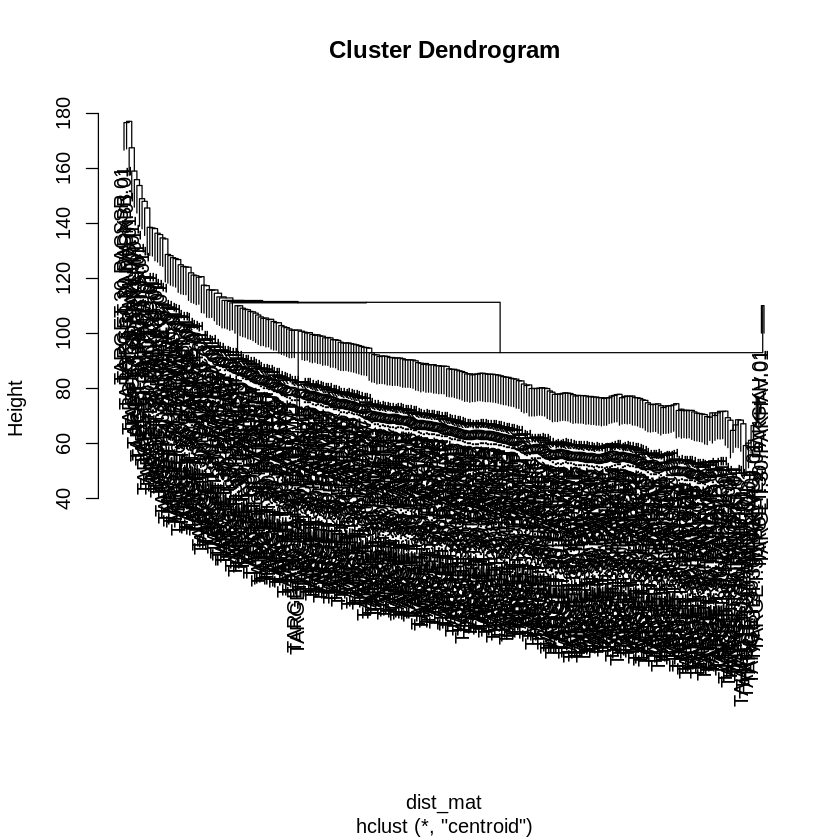

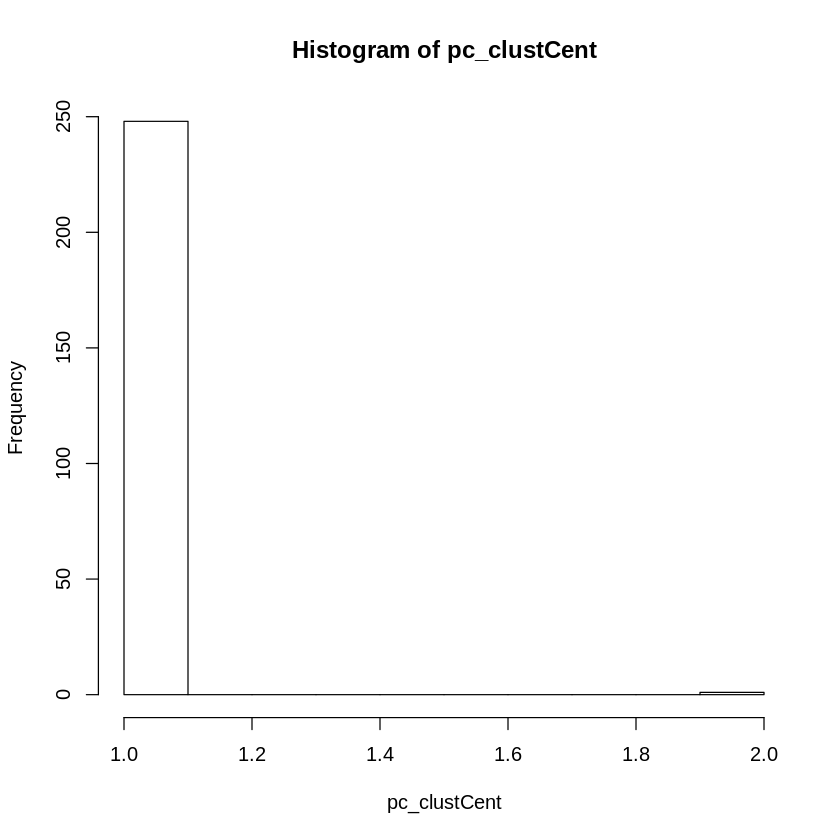

In [20]:
pc_clustCent = find_hierac_clust(pca, 'centroid')
hist(pc_clustCent)

<h3> HK Dimensionality Reduced PCA </h3>

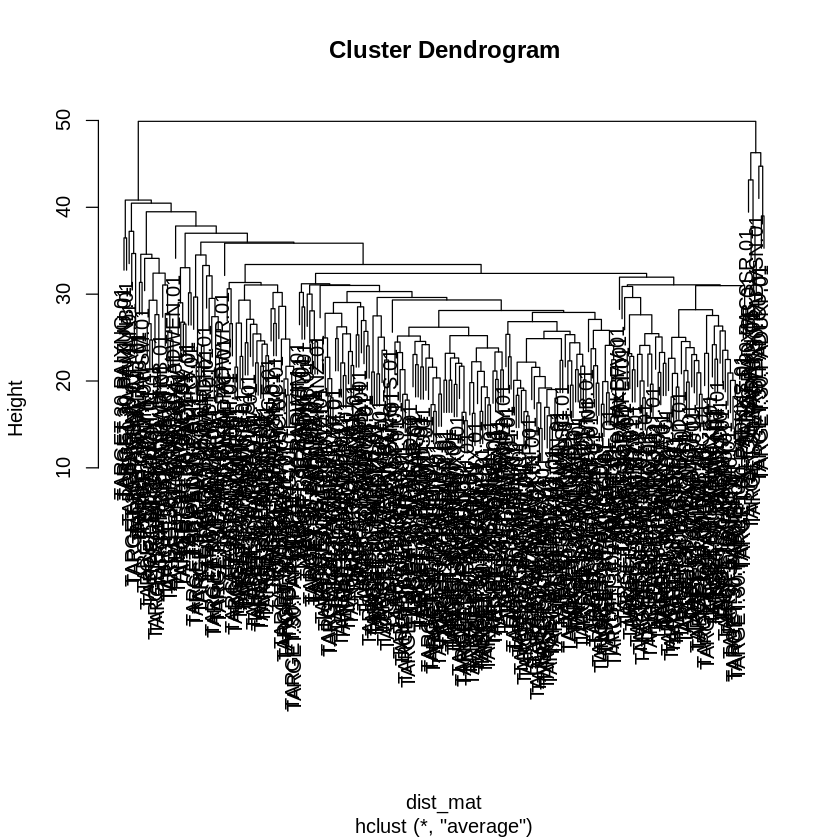

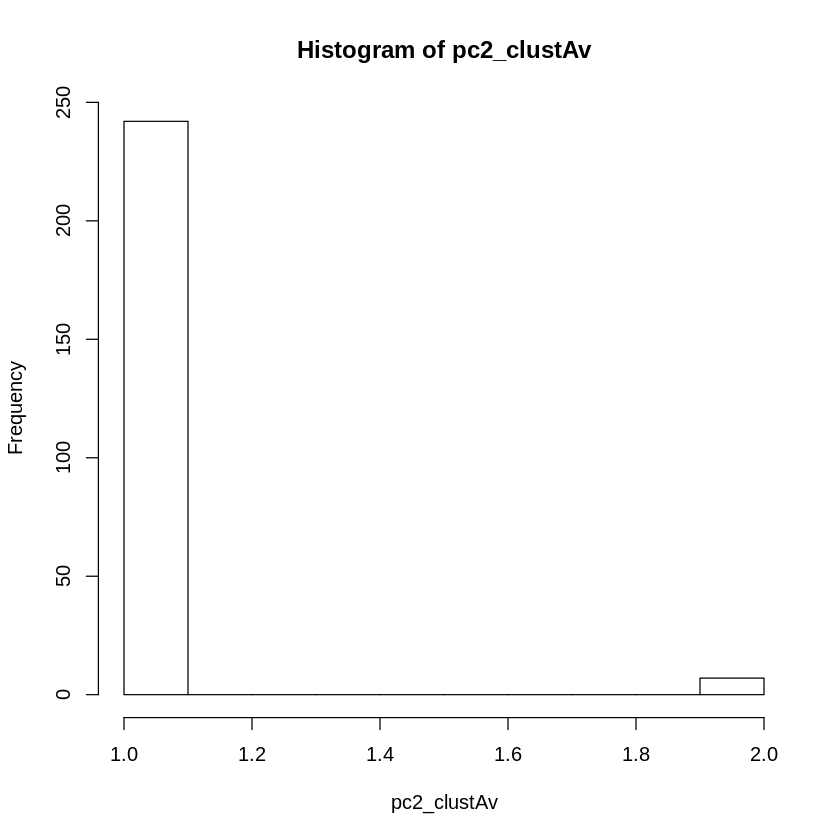

In [21]:
pc2_clustAv = find_hierac_clust(pca2,'average')
hist(pc2_clustAv)

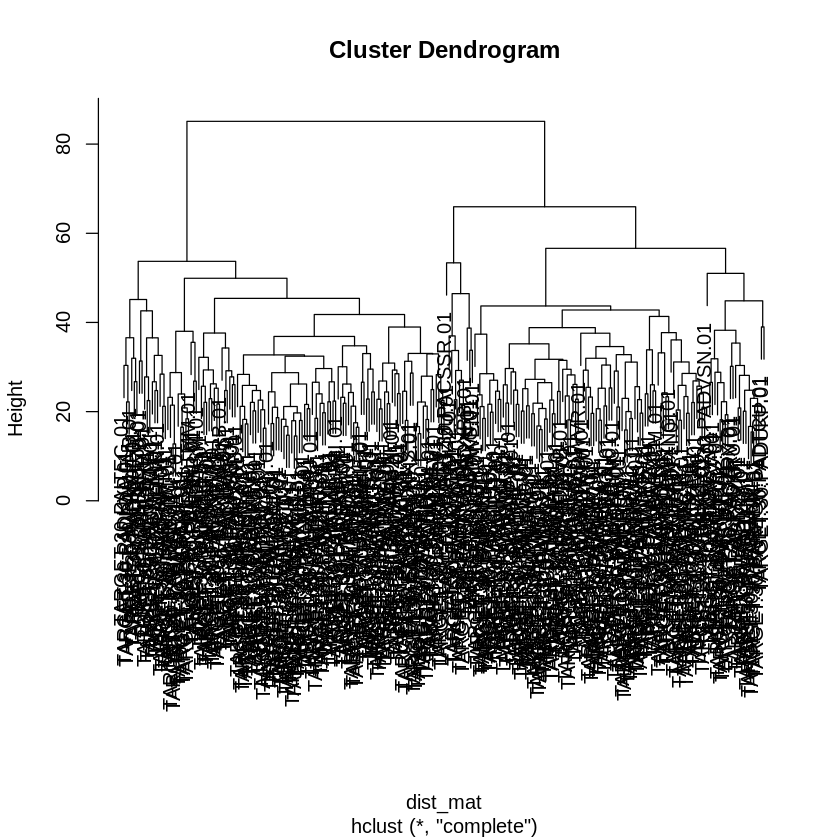

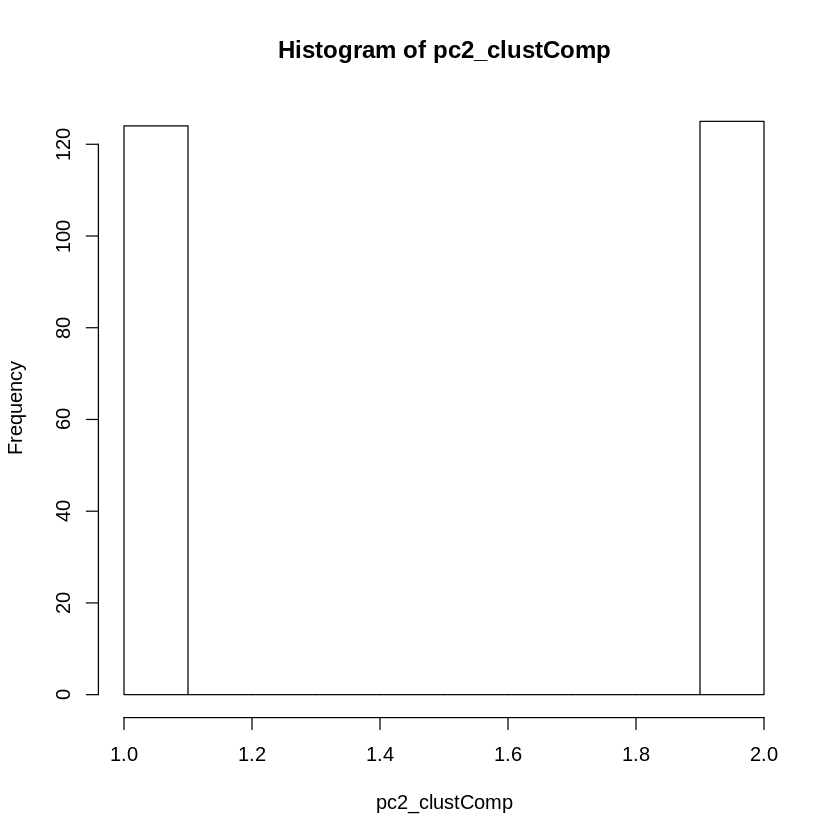

In [22]:
pc2_clustComp = find_hierac_clust(pca2, 'complete')
hist(pc2_clustComp)

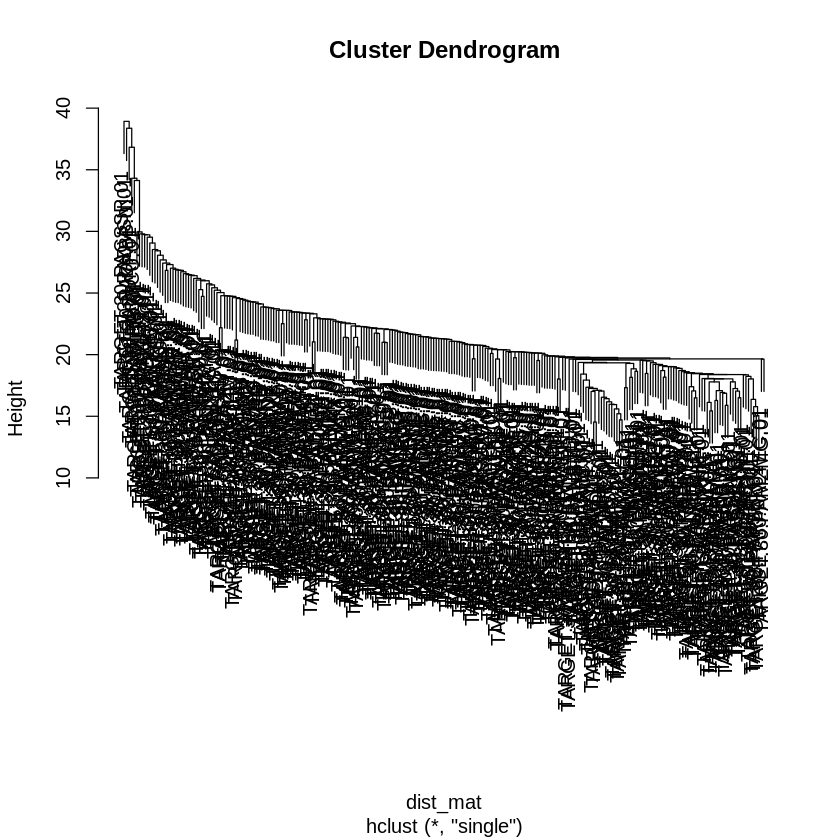

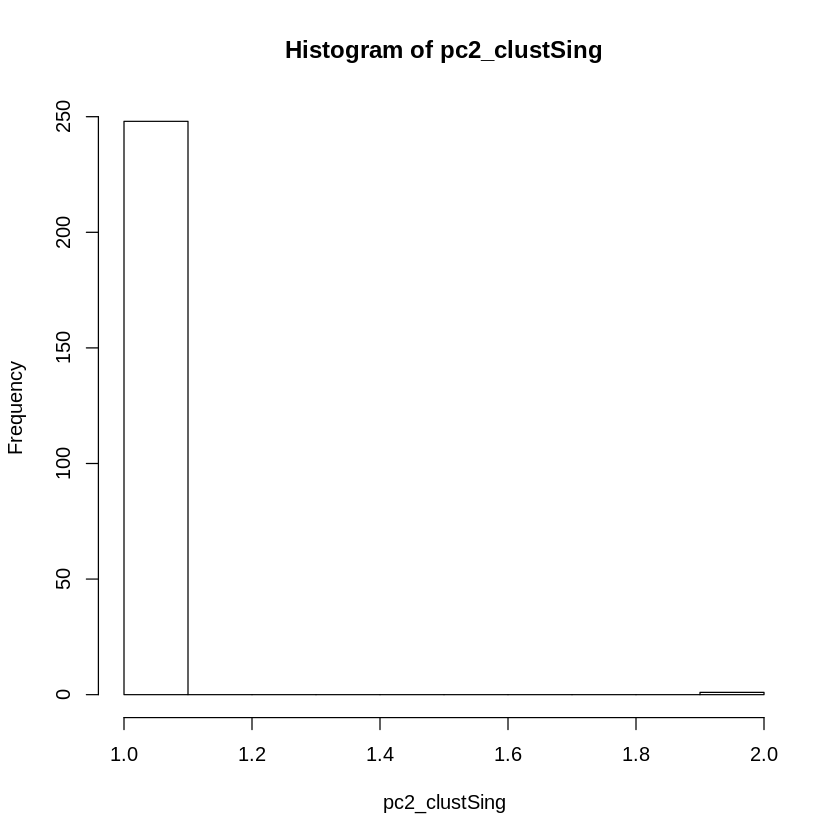

In [23]:
pc2_clustSing = find_hierac_clust(pca2, 'single')
hist(pc2_clustSing)

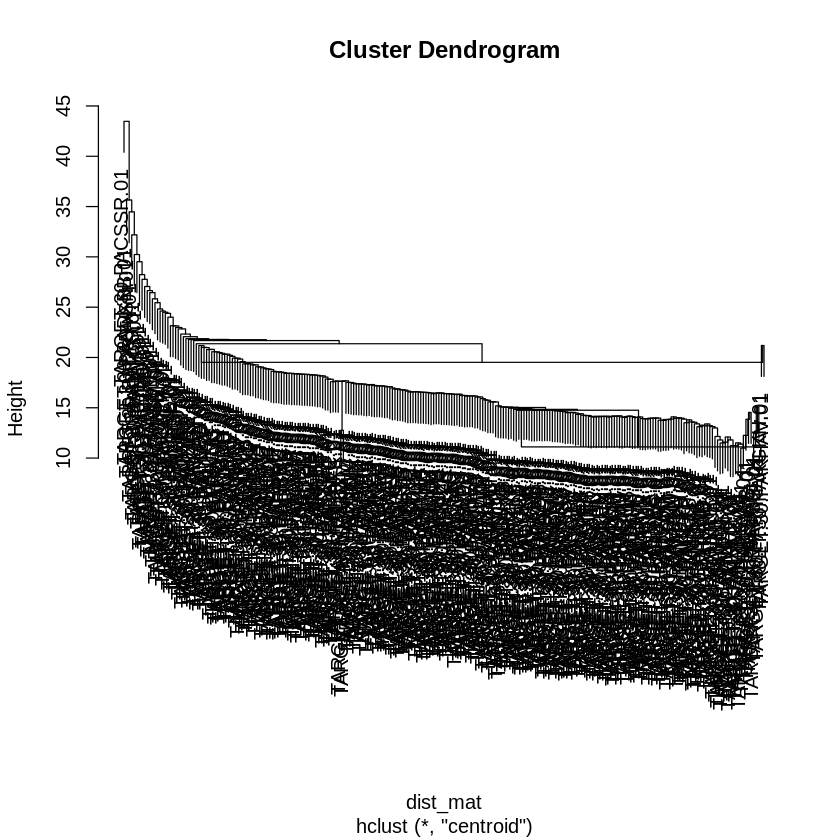

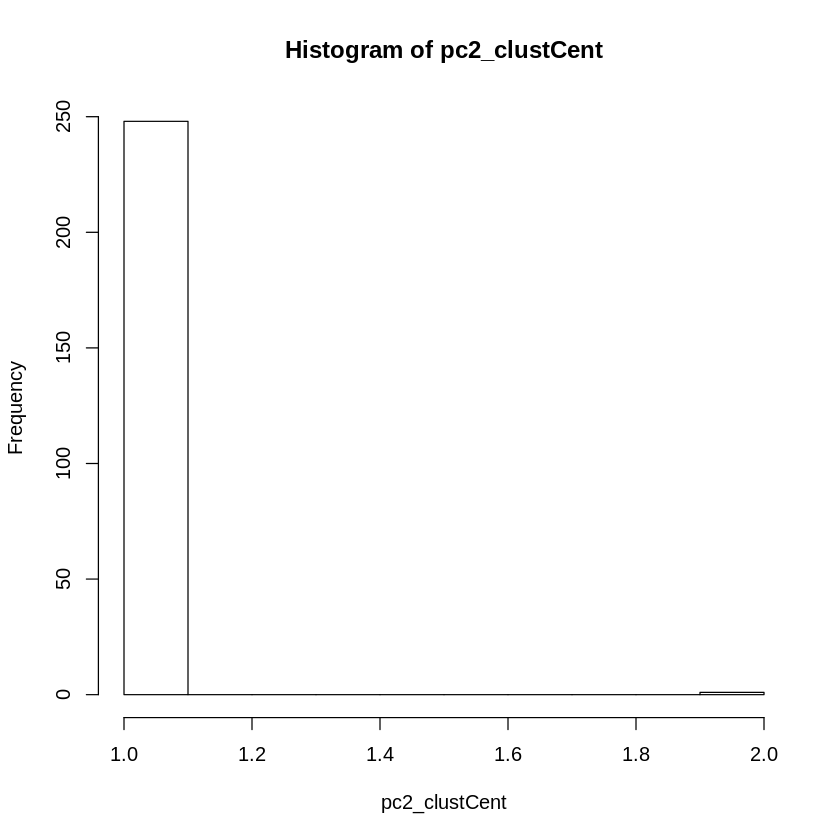

In [24]:
pc2_clustCent = find_hierac_clust(pca2, 'centroid')
hist(pc2_clustCent)

<h2> Choose Clustering and export to CSV </h2>

In [ ]:
chosen_cluster = pc2_clustComp #change based on which clustering is chosen

In [ ]:
z_scores$cluster = chosen_cluster

write.csv(z_scores, file="dr_z.csv")